In [1]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
import json
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import wordnet
from sklearn.model_selection import train_test_split, cross_validate,StratifiedKFold
from pickle import load
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.merge import concatenate
#from sklearn.pipeline import Pipel
import pandas as pd
import numpy as np
import ast
import string
import nltk
import matplotlib.pyplot as plt
#nltk.download('wordnet')
import seaborn as sns
from sklearn import svm
from sklearn import metrics
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix,roc_auc_score
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

In [2]:
from google.colab import drive
drive.mount('/content/drive/')
#drive.mount('/content/drive/Meu Drive/Colab_Notebooks/elliptic_bitcoin_dataset/')

Mounted at /content/drive/


In [3]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/elliptic_bitcoin_dataset/')  

Importing Data Files

In [4]:
df_features = pd.read_csv("elliptic_txs_features.csv")
df_edgelist = pd.read_csv("elliptic_txs_edgelist.csv")
df_classes =  pd.read_csv("elliptic_txs_classes.csv")


In [5]:
df_features.shape


(203768, 167)

In [6]:
df_edgelist.shape


(234355, 2)

In [7]:
df_classes.shape

(203769, 2)

In [8]:
#Features. Each node has associated 166 features. The first 94 features represent local information about the transaction – including the time step, 
# number of inputs/outputs, transaction fee, output volume and aggregated figures such as average BTC received (spent) by the inputs/outputs and average 
#number of incoming (outgoing) transactions associated with the inputs/outputs. The remaining 72 features, called aggregated features, are obtained 
#by aggregating transaction information one-hop backward/forward from the center node - giving the maximum, minimum, standard deviation and
#correlation coefficients of the neighbour transactions for the same information data (number of inputs/outputs, transaction fee, etc.).

df_features=pd.DataFrame(df_features.values, columns = ["Feature {}".format(i) for i in range(df_features.shape[1])])
df_features

,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,Feature 10,Feature 11,Feature 12,Feature 13,Feature 14,Feature 15,Feature 16,Feature 17,Feature 18,Feature 19,Feature 20,Feature 21,Feature 22,Feature 23,Feature 24,Feature 25,Feature 26,Feature 27,Feature 28,Feature 29,Feature 30,Feature 31,Feature 32,Feature 33,Feature 34,Feature 35,Feature 36,Feature 37,Feature 38,Feature 39,...,Feature 127,Feature 128,Feature 129,Feature 130,Feature 131,Feature 132,Feature 133,Feature 134,Feature 135,Feature 136,Feature 137,Feature 138,Feature 139,Feature 140,Feature 141,Feature 142,Feature 143,Feature 144,Feature 145,Feature 146,Feature 147,Feature 148,Feature 149,Feature 150,Feature 151,Feature 152,Feature 153,Feature 154,Feature 155,Feature 156,Feature 157,Feature 158,Feature 159,Feature 160,Feature 161,Feature 162,Feature 163,Feature 164,Feature 165,Feature 166
0,5530458.0,1.0,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,-0.167948,-0.049707,-0.164417,-0.028741,-0.035391,-0.042955,-0.013282,-0.055327,-0.169757,-0.171477,-0.174490,0.887058,0.884557,-0.139731,-0.148912,-0.080147,-0.155661,-0.010763,-0.012107,-0.139733,-0.148907,-0.080147,-0.155661,-0.010669,-0.012005,-0.024669,-0.031272,-0.023045,-0.026215,0.001428,...,-0.097719,-0.127462,0.003143,0.002426,-0.121330,-0.110933,-0.075909,-0.111641,-1.159649,-1.160129,-1.373723,-1.353918,-0.295982,-1.403215,-0.975738,-0.975237,-0.168742,-0.263290,-0.186389,-0.250875,-1.015963,-1.016230,-0.968903,0.146997,1.366287,-0.464773,-1.116918,-1.116948,-0.216814,0.634272,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,232022460.0,1.0,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,-0.168576,-0.049707,-0.165054,-0.028741,-0.035391,-0.042955,-0.013282,-0.055298,-0.170400,-0.172217,-0.175227,0.887058,0.884557,-0.139729,-0.148911,-0.080147,-0.155660,-0.010763,-0.012107,-0.139731,-0.148906,-0.080147,-0.155660,-0.010669,-0.012005,-0.024669,-0.031272,-0.023045,-0.026215,0.001428,...,-0.097719,-0.129496,0.003143,0.002426,-0.122974,-0.041556,0.012549,-0.032244,-1.159649,-1.160129,-1.373902,-1.356210,-0.301548,-1.404577,-0.975738,-0.975237,-0.168742,-0.192468,-0.099790,-0.182133,-1.015963,-1.016230,-0.968903,-1.421138,-0.453330,-1.375441,-1.116918,-1.116948,-0.216814,0.407161,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
2,232438397.0,1.0,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,-0.115831,0.043598,-0.163905,1.059993,2.397457,-0.063200,-0.013282,4.800240,0.174329,-0.172908,0.619399,-0.243300,-0.243452,-0.139732,-0.146895,-0.079667,-0.155554,0.773847,0.378516,-0.139734,-0.146891,-0.079667,-0.155553,0.773932,0.378593,-0.024669,-0.031271,-0.023044,-0.026215,0.101008,...,0.019771,-0.119195,0.147881,0.956170,0.759756,-0.041556,-0.188716,0.149949,-0.047722,-0.048171,-1.373723,-1.356131,-0.301754,-1.404445,0.183133,0.182748,-0.163577,-0.456561,-0.424672,-0.436915,0.143001,0.142525,-0.425896,-1.421138,-1.059868,-1.071885,0.185597,0.185492,-0.216814,-0.617907,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
3,230460314.0,1.0,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,0.041399,0.935886,-0.098695,1.203038,0.988902,0.341693,-0.013282,-0.057392,0.058329,-0.032930,-0.042709,0.065455,0.324947,-0.139732,-0.148854,-0.080105,-0.155638,1.313051,1.106965,-0.139734,-0.148850,-0.080104,-0.155638,1.313130,1.106995,-0.024669,-0.031272,-0.023045,-0.026215,0.001428,...,-0.077909,-0.093120,1.587690,1.586539,-0.101820,0.704558,0.448898,0.659662,0.311091,0.302198,-1.373962,-1.355393,-0.300941,-1.404583,0.064846,-0.035232,-0.168742,-0.442156,-0.416540,-0.418273,0.367605,0.392035,-0.968903,-1.943850,-1.059868,-1.678997,0.185597,0.185492,-0.169472,-0.470592,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.

In [9]:
boolean =df_features['Feature 0'].duplicated().any()
boolean

False

Data distribution across all the features

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10
#df_temp=df_features.drop("label",axis=1)
df_temp=df_features.drop("Feature 0",axis=1)
plt.xticks(rotation=90)
sns.boxplot(data=pd.melt(df_temp),x="variable", y="value")
plt.savefig("aalinone")

In [11]:
from pylab import rcParams
rcParams['figure.figsize'] = 15,10

Plot 10 features at a time

In [ ]:
#df_temp=df_features.drop("label",axis=1)
#df_temp=df_temp.drop("Feature 0",axis=1)
for i in range(0,166,10):
  if i!=160:
    sns.boxplot(data=pd.melt(df_temp.iloc[:,i:i+10]),x="variable", y="value")
  else:
    sns.boxplot(data=pd.melt(df_temp.iloc[:,i:i+6]),x="variable", y="value")
  plt.xticks(rotation=75)
  name="plots/"+str(i)
  #plt.savefig(name)
  plt.show()

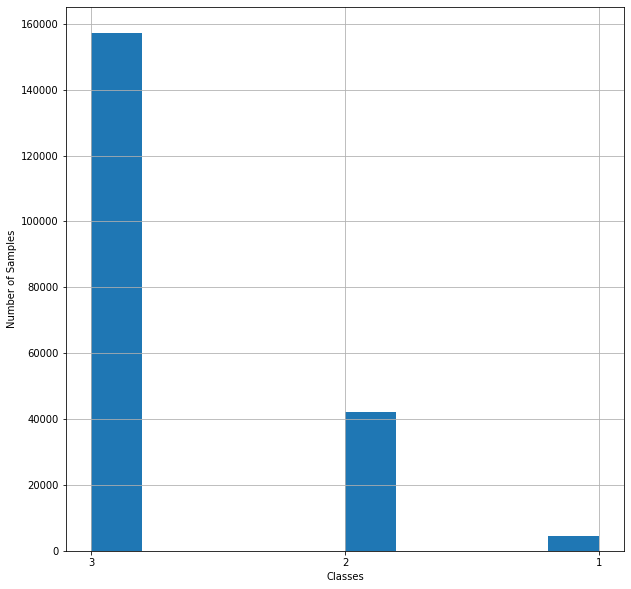

In [13]:
df_classes =  pd.read_csv("elliptic_txs_classes.csv")
df_classes=df_classes.replace("unknown","3")
df_classes = df_classes.iloc[1:]
plt.figure(figsize=(10,10))
plt.xlabel("Classes")
plt.ylabel("Number of Samples")
hist = df_classes['class'].hist()
plt.savefig("Class distribution2")

In [14]:
df_features["label"]=df_classes[["class"]]

Labelling the data

In [15]:
df_unlabelled=df_features.loc[df_features['label'] == "3"]

In [16]:
df_labelled=df_features.loc[df_features['label'].isin(["1","2"])]

In [17]:
df_labelled["label"].replace({"1": 1, "2": 2}, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [18]:
df_labelled=df_labelled.iloc[:3000,:]

In [19]:
boolean =df_features['label'].isnull().values.any()
df_labelled = df_labelled.dropna(how='all')
#df_features.shape
df_labelled.shape

(3000, 168)

Illicit Vs licit comparision at each timeframe

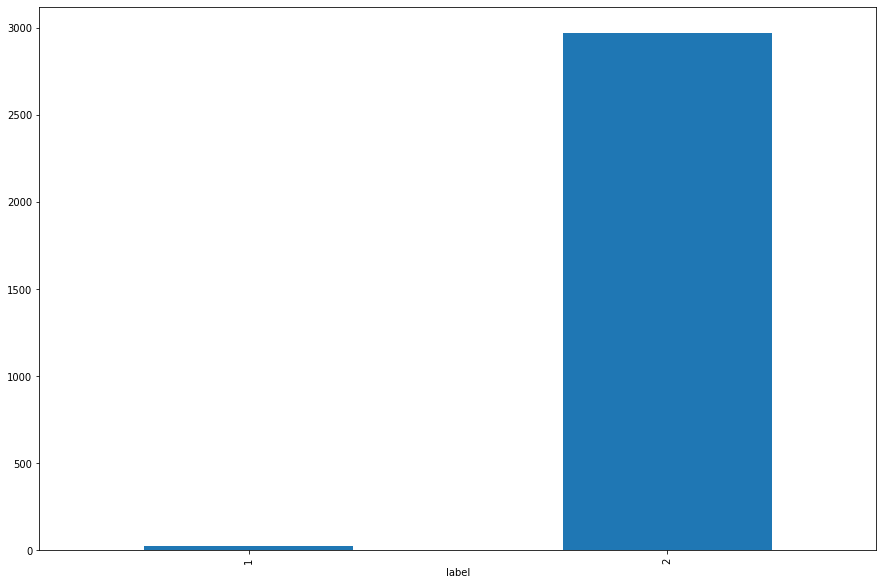

In [20]:
df_labelled.groupby('label').size().plot(kind='bar')
plt.show()

Distribution of licit vS illicit at each timeframe

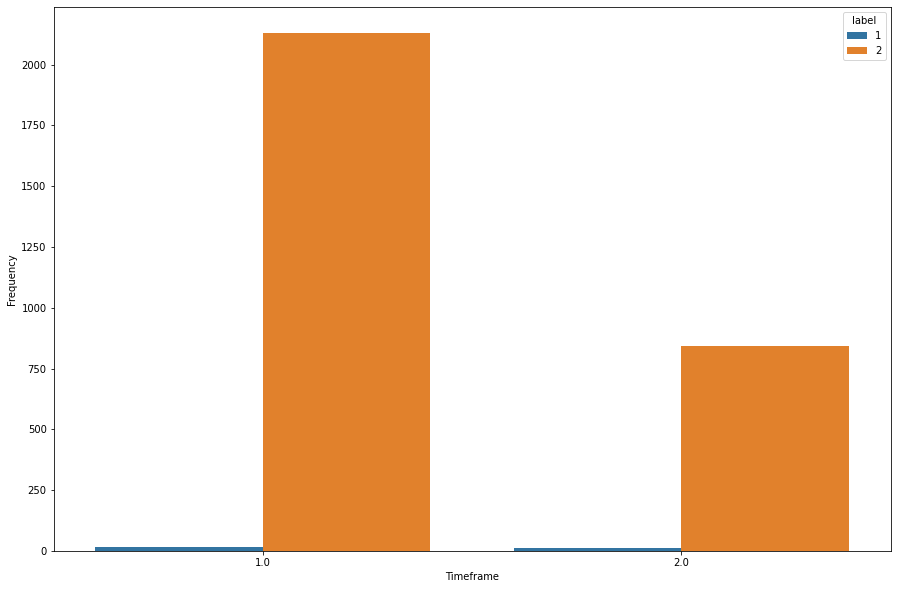

In [21]:
sns.countplot(data=df_labelled,x=df_labelled.columns[1],hue="label")
plt.xlabel("Timeframe")
plt.ylabel("Frequency")
plt.savefig("Distribution")
plt.show() 

TSNE

In [22]:
import seaborn as sns
from sklearn.manifold import TSNE
#d2.insert(100, "100", output, True) 
#print(d2)
df_subset=pd.DataFrame()

df_labelled = df_labelled[df_labelled.notna()]

d2=df_labelled
y=d2[["label"]]
d2 = d2.drop("label",axis=1)

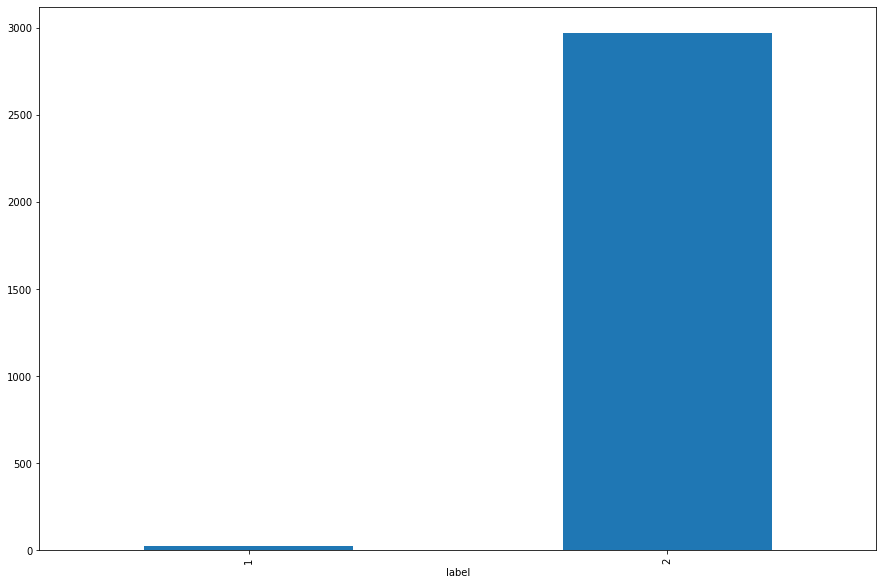

In [23]:
df_labelled.groupby('label').size().plot(kind='bar')
plt.show()

In [24]:
#boolean =df_labelled['label'].isnull().any()
#boolean

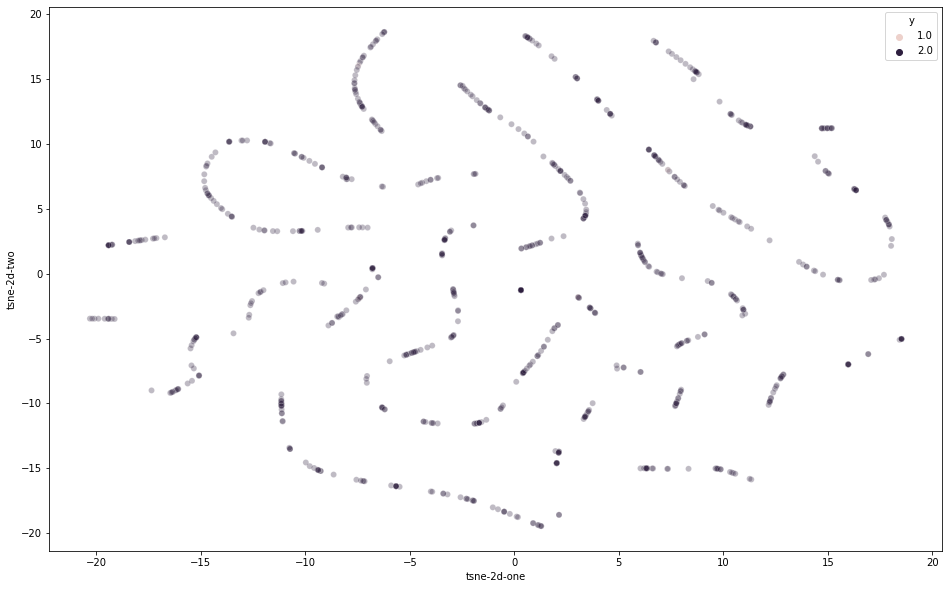

In [25]:
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(df_labelled)
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
df_subset["y"]=y
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    data=df_subset,
    legend="full",
    alpha=0.3
)
plt.savefig("tsne")
plt.show()

In [26]:
df_labelled['label'].isnull().sum()


0

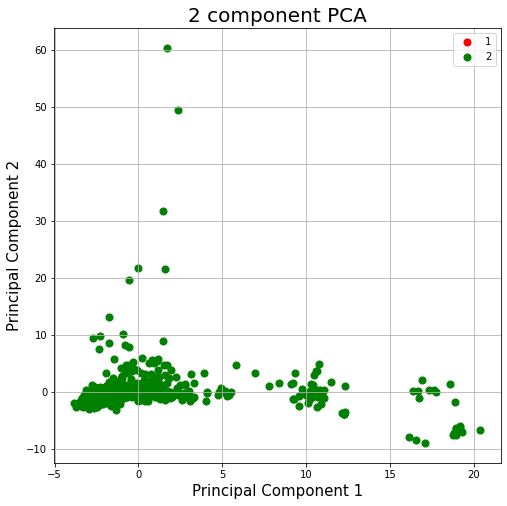

In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


df_labelled = df_labelled[df_labelled['label'].notna()]
# Separating out the features
x=df_labelled.drop("label",axis=1).values

# Separating out the target
y = df_labelled.loc[:,['label']].values



x = StandardScaler().fit_transform(x)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

finalDf = pd.concat([principalDf, df_labelled[['label']]], axis = 1)


finalDf = finalDf[finalDf['label'].notna()]

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [1, 2]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['label'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [28]:
pca.explained_variance_ratio_

array([0.10762032, 0.05968961])

In [29]:
pca_features = pca.components_



PCA

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(d2, y, test_size=0.5)

In [31]:
d2.shape

(3000, 167)

In [32]:
x = df_labelled.values
y = df_labelled['label'].values

x=df_labelled.iloc[:,:-1]
y=df_labelled.iloc[:, -1]

In [33]:
x_train,x_test, y_train, y_test=train_test_split(x,y,test_size=0.30)


In [34]:
from sklearn.svm import SVC
model=SVC()
model.fit(x_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [35]:
pred=model.predict(x_test)

In [36]:
from sklearn.metrics import classification_report, confusion_matrix

In [37]:
print(confusion_matrix(y_test,pred))

[[  0  10]
 [  0 890]]


In [38]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        10
           2       0.99      1.00      0.99       890

    accuracy                           0.99       900
   macro avg       0.49      0.50      0.50       900
weighted avg       0.98      0.99      0.98       900



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [40]:
#!pip install mlrose
#oversample
import six
import sys
sys.modules['sklearn.externals.six'] = six
import mlrose
from imblearn.over_sampling import ADASYN 
ada = ADASYN() 
X_resampled, y_resampled = ada.fit_sample(x_train, y_train) 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [41]:
model.fit(X_resampled, y_resampled)
pred=model.predict(x_test)
print(confusion_matrix(y_test,pred))
print(classification_report(y_test, pred))

[[  5   5]
 [432 458]]
              precision    recall  f1-score   support

           1       0.01      0.50      0.02        10
           2       0.99      0.51      0.68       890

    accuracy                           0.51       900
   macro avg       0.50      0.51      0.35       900
weighted avg       0.98      0.51      0.67       900



In [42]:
from imblearn.under_sampling import RandomUnderSampler 
rus = RandomUnderSampler() 
x_resampled, y_resampled = rus.fit_sample(x_train, y_train) 
model.fit(x_resampled, y_resampled)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [43]:
pred=model.predict(x_test)
print(confusion_matrix(y_test,pred))
print(classification_report(y_test, pred))

[[  4   6]
 [347 543]]
              precision    recall  f1-score   support

           1       0.01      0.40      0.02        10
           2       0.99      0.61      0.75       890

    accuracy                           0.61       900
   macro avg       0.50      0.51      0.39       900
weighted avg       0.98      0.61      0.75       900



Baseline Baseline

In [46]:
from sklearn.svm import OneClassSVM 
train, test = train_test_split(df_labelled, test_size=.2) 
train_normal = train[train['label']==2] 
train_outliers = train[train['label']==1] 
outlier_prop = len(train_outliers) / len(train_normal) 
svm = OneClassSVM(kernel='rbf', nu=outlier_prop, gamma=0.000001) 
svm.fit(train_normal)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=1e-06, kernel='rbf',
            max_iter=-1, nu=0.009676062263357174, shrinking=True, tol=0.001,
            verbose=False)

In [47]:

# define outlier detection model
model = OneClassSVM(gamma='scale', nu=0.01)

In [48]:
# fit on majority class
trainX = train[train['label']==2] 
model.fit(trainX)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='scale', kernel='rbf',
            max_iter=-1, nu=0.01, shrinking=True, tol=0.001, verbose=False)

In [52]:
target = df_labelled['label']
outliers = target[target == 1]

print("outliers.shape", outliers.shape)
print("outlier fraction", outliers.shape[0]/target.shape[0])

outliers.shape

outliers.shape (28,)
outlier fraction 0.009333333333333334


(28,)

In [50]:
#data.drop(["label", "attack"], axis=1, inplace=True)

data=df_labelled.iloc[:,:-1]
#y=df_labelled.iloc[:, -1]
data.shape

(3000, 167)

In [53]:
from sklearn.model_selection import train_test_split
train_data, test_data, train_target, test_target = train_test_split(data, target, train_size = 0.8)
train_data.shape

(2400, 167)

In [54]:
from sklearn import svm
# set nu (which should be the proportion of outliers in our dataset) 
nu = outliers.shape[0] / target.shape[0]
print("nu", nu)
model = svm.OneClassSVM(nu=nu, kernel='rbf', gamma=0.00005) 
model.fit(train_data)

nu 0.009333333333333334


OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=5e-05, kernel='rbf',
            max_iter=-1, nu=0.009333333333333334, shrinking=True, tol=0.001,
            verbose=False)

In [59]:
from sklearn import metrics
preds = model.predict(train_data)
targs = train_target 
print("accuracy: ", metrics.accuracy_score(targs, preds))
print("precision: ", metrics.precision_score(targs, preds, average='micro')) 
print("recall: ", metrics.recall_score(targs, preds, average='micro'))
print("f1: ", metrics.f1_score(targs, preds, average='micro'))
print("area under curve (auc): ", metrics.roc_auc_score(targs, preds))

accuracy:  0.005416666666666667
precision:  0.005416666666666667
recall:  0.005416666666666667
f1:  0.005416666666666667
area under curve (auc):  0.49368686868686873


In [ ]:
## Parei aqui .... refazer OneClassSVM

Naive Stratified Sampling

In [ ]:
from sklearn.model_selection import train_test_split
df_1=df_labelled.loc[df_labelled['label'] == 1]
y_1 = df_1[["label"]]
df_1=df_1.drop('label',axis=1)
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(df_1, y_1, test_size=0.2)

df_2=df_labelled.loc[df_labelled['label'] == 2]
y_2 = df_2[["label"]]
df_2=df_2.drop("label",axis=1)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(df_2, y_2, test_size=0.9)

In [ ]:
train_trying_x_1 = X_train_1.append(X_train_2)
train_trying_y_1 = y_train_1.append(y_train_2)
test_trying_x_1 = X_test_1.append(X_test_2)
test_trying_y_1 = y_test_1.append(y_test_2)

Baseline with naive stratified sampling

In [ ]:
!pip install lazypredict

In [ ]:
import lazypredict
from lazypredict.Supervised import LazyClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(train_trying_x_1, test_trying_x_1, train_trying_y_1, test_trying_y_1)
models

Baseline Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(train_trying_x_1, train_trying_y_1)
y_pred = clf.predict(test_trying_x_1)
print(confusion_matrix(test_trying_y_1, y_pred))
print(classification_report(test_trying_y_1, y_pred))
metrics.plot_roc_curve(clf, test_trying_x_1, test_trying_y_1)
plt.savefig("roc_log")  # doctest: +SKIP
plt.show()  
roc_auc_score(test_trying_y_1, y_pred) 
sns.heatmap(confusion_matrix(test_trying_y_1, y_pred), annot=True, annot_kws={"size": 14}, fmt='g')
plt.savefig("logistic.png")

SVM

In [ ]:
from sklearn import svm
from sklearn import metrics
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix,roc_auc_score
#Create a svm Classifier
clf = svm.SVC(kernel='rbf',C=5)# Linear Kernel

#Train the model using the training sets
clf.fit(train_trying_x_1, train_trying_y_1)

#Predict the response for test dataset
y_pred = clf.predict(test_trying_x_1)
print(confusion_matrix(test_trying_y_1, y_pred))
print(classification_report(test_trying_y_1, y_pred))
metrics.plot_roc_curve(clf, test_trying_x_1, test_trying_y_1)  # doctest: +SKIP
plt.savefig("roc_svc")
plt.show()  
roc_auc_score(test_trying_y_1, y_pred)
sns.heatmap(confusion_matrix(test_trying_y_1, y_pred), annot=True, annot_kws={"size": 14}, fmt='g')
plt.savefig("svc.png")

Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=1000, random_state=0).fit(train_trying_x_1, train_trying_y_1)
y_pred = clf.predict(test_trying_x_1)
print(confusion_matrix(test_trying_y_1, y_pred))
print(classification_report(test_trying_y_1, y_pred))
metrics.plot_roc_curve(clf, test_trying_x_1, test_trying_y_1)  # doctest: +SKIP
plt.savefig("roc_rf")
plt.show()  
roc_auc_score(test_trying_y_1, y_pred)
sns.heatmap(confusion_matrix(test_trying_y_1, y_pred), annot=True, annot_kws={"size": 14}, fmt='g')
plt.savefig("rf.png")

In [ ]:
type(test_trying_x_1)

Kfold for random forest and SVM

In [ ]:
from sklearn.model_selection import GridSearchCV 
param_grid = {'C': [0.1,1,5,10],  
              'gamma': [1, 0.1, 0.01,"scale"], 
              'kernel': ['rbf']}  

train_trying_y_1=train_trying_y_1
test_trying_y_1 = test_trying_y_1
grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 0,scoring="f1",cv=10) 
  
# fitting the model for grid search 
grid.fit(train_trying_x_1, train_trying_y_1) 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 
y_pred = grid.predict(test_trying_x_1)
print(confusion_matrix(test_trying_y_1, y_pred))
print(classification_report(test_trying_y_1, y_pred))
metrics.plot_roc_curve(grid, test_trying_x_1, test_trying_y_1)  # doctest: +SKIP
plt.savefig("svm_grid.png")
plt.show()
sns.heatmap(confusion_matrix(test_trying_y_1, y_pred), annot=True, annot_kws={"size": 14}, fmt='g')
plt.savefig("svm_heat_grid.png")

plt.show()
roc_auc_score(test_trying_y_1, y_pred) 

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
param_grid = [
{'n_estimators': [10, 25,50,100], 'max_features': [5, 10,15,20,100], 
 'max_depth': [10,100,None]}
]

train_trying_y_1=train_trying_y_1
test_trying_y_1 = test_trying_y_1
forest = RandomForestClassifier()
h_forest = GridSearchCV(forest, param_grid, cv=5, scoring='f1',verbose=0)
h_forest.fit(train_trying_x_1, train_trying_y_1)
print(h_forest.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(h_forest.best_estimator_) 
y_pred = h_forest.predict(test_trying_x_1)
print(confusion_matrix(test_trying_y_1, y_pred))
print(classification_report(test_trying_y_1, y_pred))
metrics.plot_roc_curve(h_forest, test_trying_x_1, test_trying_y_1)  # doctest: +SKIP
plt.savefig("rf_grid.png")
plt.show()
sns.heatmap(confusion_matrix(test_trying_y_1, y_pred), annot=True, annot_kws={"size": 14}, fmt='g')
plt.savefig("rf_heat_grid.png")


In [ ]:
feat_importances = pd.Series(clf.feature_importances_, index=df_1.columns)
feat_importances.nlargest(15).plot(kind='barh')
#plt.saveplot("featureimp")

**Preprocessing**

In [ ]:
print(y)
d2

In [ ]:
std = StandardScaler()
X_preprocessed = std.fit_transform(d2)
scaled_features_df = pd.DataFrame(X_preprocessed, index=d2.index, columns=d2.columns)

In [ ]:
corr = scaled_features_df.corr()
f = plt.figure(figsize=(19, 15))
plt.matshow(corr, fignum=f.number)
plt.xticks(range(scaled_features_df.shape[1]), scaled_features_df.columns, fontsize=14, rotation=45)
plt.yticks(range(scaled_features_df.shape[1]), scaled_features_df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);
plt.savefig("Correlation plot")

In [ ]:
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

In [ ]:
print(to_drop)

In [ ]:
df_preprocessed = scaled_features_df.drop(scaled_features_df[to_drop], axis=1)

In [ ]:
df_preprocessed

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10
#df_temp=df_features.drop("label",axis=1)
df_temp=df_preprocessed.drop("Feature 0",axis=1)
plt.xticks(rotation=90)
sns.boxplot(data=pd.melt(df_temp),x="variable", y="value")
plt.savefig("Updated Boxplot")

In [ ]:
from sklearn.model_selection import train_test_split
df_labelled = pd.concat([df_preprocessed, y], axis=1)
df_1=df_labelled.loc[df_labelled['label'] == "1"]
y_1 = df_1[["label"]]
df_1=df_1.drop('label',axis=1)
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(df_1, y_1, test_size=0.2)

df_2=df_labelled.loc[df_labelled['label'] == "2"]
y_2 = df_2[["label"]]
df_2=df_2.drop("label",axis=1)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(df_2, y_2, test_size=0.9)

train_trying_x_1 = X_train_1.append(X_train_2)
train_trying_y_1 = y_train_1.append(y_train_2)
test_trying_x_1 = X_test_1.append(X_test_2)
test_trying_y_1 = y_test_1.append(y_test_2)

In [ ]:
from sklearn.svm import SVC
clf = SVC().fit(train_trying_x_1, train_trying_y_1)
plt.figure(figsize=(7,7))
y_pred = clf.predict(test_trying_x_1)
print(confusion_matrix(test_trying_y_1, y_pred))
print(classification_report(test_trying_y_1, y_pred))
metrics.plot_roc_curve(clf, test_trying_x_1, test_trying_y_1)  # doctest: +SKIP
plt.savefig("roc_rf2.png")
plt.show()  
plt.figure(figsize=(7,7))
roc_auc_score(test_trying_y_1, y_pred)
sns.heatmap(confusion_matrix(test_trying_y_1, y_pred), annot=True, annot_kws={"size": 14}, fmt='g')
plt.savefig("rf2.png")

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score
from sklearn import tree


df = pd.read_csv("mlq5.csv")



# from sklearn.preprocessing import LabelEncoder
# Le = LabelEncoder()

# df['Outlook'] = Le.fit_transform(df['Outlook'])
# df['Climate'] = Le.fit_transform(df['Climate'])
# df['Humidity'] = Le.fit_transform(df['Humidity'])
# df['Wind'] = Le.fit_transform(df['Wind'])
# df['PlayMatch'] = Le.fit_transform(df['PlayMatch'])

y = df['PlayMatch']
df = df.drop(['PlayMatch'], axis=1)
df = pd.get_dummies(df)

X_train = df.iloc[:7,:]
X_test = df.iloc[8:,:]

y_train = y.iloc[:7]
y_test = y.iloc[8:]

print(X_train.head())

clf = DecisionTreeClassifier(random_state=1234)
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_pred, y_test))
print(accuracy_score(clf.predict(X_train), y_train))

import graphviz 
dot_data = tree.export_graphviz(clf, feature_names=df.columns ,out_file=None) 
graph = graphviz.Source(dot_data) 

graph
# fig = plt.figure(figsize=(25,20))
# _ = tree.plot_tree(clf, 
#                    feature_names=X.columns,  
#                    class_names=y.columns,
#                    filled=True)


# print(df[(df['Outlook']!="Overcast") & (df['PlayMatch']=="No")].shape[0])

# print(df[((df['Outlook']!="Rainy") & (df['Outlook']!="Sunny")) & (df['PlayMatch']=="No")].shape[0])

Installing Deepwalk

In [ ]:
!git clone https://github.com/phanein/deepwalk.git

In [ ]:
os.chdir('/content/gdrive/My Drive/Bitcoin/deepwalk/') 
!pip install -r requirements.txt
!python setup.py install

Running deepwalk on edgelist

In [ ]:
os.chdir('/content/gdrive/My Drive/Bitcoin/')
!deepwalk --input new_edgelist --format edgelist --output abc

Seperating node and features

In [ ]:
with open("abc") as fp:
  fp=fp.read().splitlines()
t={x[:x.index(" ")]:x[x.index(" ")+1:] for x in fp[1:]}

In [ ]:
fp[1]

In [ ]:
t

matching node id with labelled data

In [ ]:
x=[]
y=[]
for i in t:
  if len(df_classes[df_classes["txId"]==int(i)])!=0:
    #for j in df_labelled[df_labelled.columns[0]]:
    x.append(t[i])
    y.append(df_classes[df_classes["txId"]==int(i)]["class"])
    #print("dvvxxxads")

Naive Stratifies Sampling and converting embedding string to list of floats

In [ ]:
tx_1=[]
ty_1=[]
tx_2=[]
ty_2=[]
for n,i in enumerate(y):
  if i.values[0]=="1":
    ttttt=[]
    for k in x[n].split(" "):
      ttttt.append(float(k))
    tx_1.append(np.array(ttttt))
    ty_1.append([int(i.values[0])])
  elif i.values[0]=="2":
    ttttt=[]
    for k in x[n].split(" "):
      ttttt.append(float(k))
    tx_2.append(np.array(ttttt))
    ty_2.append([int(i.values[0])])

In [ ]:
len(tx_2),len(df_labelled)

In [ ]:
from sklearn.model_selection import train_test_split

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(tx_1, ty_1, test_size=0.2)

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(tx_2, ty_2, test_size=0.9)


In [ ]:

train_trying_x_1 =[]
train_trying_y_1 =[]
test_trying_x_1  = []
test_trying_y_1  = [] 

for i in X_train_1:
  train_trying_x_1.append(i)
for i in X_train_2:
  train_trying_x_1.append(i)
for i in X_test_1:
  test_trying_x_1.append(i)
for i in X_test_2:
  test_trying_x_1.append(i)

for i in y_train_1:
  train_trying_y_1.append(i)
for i in y_train_2:
  train_trying_y_1.append(i)
for i in y_test_1:
  test_trying_y_1.append(i)
for i in y_test_2:
  test_trying_y_1.append(i)

In [ ]:
X_train_1[0]

In [ ]:
np.array(y_train_1).shape,np.array(X_train_1).shape

Random Forest, SVM and their KFold versions

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=1000, random_state=0).fit(train_trying_x_1, train_trying_y_1)
y_pred = clf.predict(test_trying_x_1)
print(confusion_matrix(test_trying_y_1, y_pred))
print(classification_report(test_trying_y_1, y_pred))
metrics.plot_roc_curve(clf, test_trying_x_1, test_trying_y_1)  # doctest: +SKIP
plt.savefig("roc_rf_dw")
plt.show()  
roc_auc_score(test_trying_y_1, y_pred)
sns.heatmap(confusion_matrix(test_trying_y_1, y_pred), annot=True, annot_kws={"size": 14}, fmt='g')
plt.savefig("rf_dw.png")

In [ ]:
from sklearn.model_selection import GridSearchCV 
param_grid = {'C': [0.001,0.01,0.1,1,5,10,100],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001,10,20,"scale"], 
              'kernel': ['rbf']}  

train_trying_y_1=train_trying_y_1
test_trying_y_1 = test_trying_y_1
grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 0,scoring="f1",cv=10) 
  
# fitting the model for grid search 
grid.fit(train_trying_x_1, train_trying_y_1) 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 
y_pred = grid.predict(test_trying_x_1)
print(confusion_matrix(test_trying_y_1, y_pred))
print(classification_report(test_trying_y_1, y_pred))
metrics.plot_roc_curve(grid, test_trying_x_1, test_trying_y_1)  # doctest: +SKIP
plt.savefig("svm_grid_dw.png")
plt.show()
sns.heatmap(confusion_matrix(test_trying_y_1, y_pred), annot=True, annot_kws={"size": 14}, fmt='g')
plt.savefig("svm_heat_grid_dw.png")

plt.show()
roc_auc_score(test_trying_y_1, y_pred) 

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
param_grid = [
{'n_estimators': [10, 25,50,100], 'max_features': [5, 10,15,20,100], 
 'max_depth': [10,100,None]}
]

train_trying_y_1=train_trying_y_1
test_trying_y_1 = test_trying_y_1
forest = RandomForestClassifier()
h_forest = GridSearchCV(forest, param_grid, cv=5, scoring='f1',verbose=0)
h_forest.fit(train_trying_x_1, train_trying_y_1)
print(h_forest.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(h_forest.best_estimator_) 
y_pred = h_forest.predict(test_trying_x_1)
print(confusion_matrix(test_trying_y_1, y_pred))
print(classification_report(test_trying_y_1, y_pred))
metrics.plot_roc_curve(h_forest, test_trying_x_1, test_trying_y_1)  # doctest: +SKIP
plt.savefig("rf_grid_dw.png")
plt.show()
sns.heatmap(confusion_matrix(test_trying_y_1, y_pred), annot=True, annot_kws={"size": 14}, fmt='g')
plt.savefig("rf_heat_grid_dw.png")
